# MP2

# Outlier capping (90th percentile)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load and preprocess
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)
df.rename(columns={'TransactionPrice  ': 'TransactionPrice', 'Parcel Area': 'ParcelArea', 'Scheme Name/Area': 'SchemeName'}, inplace=True)
df['ParcelArea'] = df['ParcelArea'].astype(str).str.extract(r'(\d+\.?\d*)').astype(np.float32)
df['Tenure'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0}).fillna(0).astype(np.float32)

# Create a copy for comparison
df_before_capping = df.copy()

# Outlier capping (90th percentile)
price_cap = df['TransactionPrice'].quantile(0.90)
df['TransactionPrice'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
area_cap = df['ParcelArea'].quantile(0.90)
df['ParcelArea'] = np.clip(df['ParcelArea'], 0, area_cap).astype(np.float32)

# Count rows after capping (note: capping doesn't remove rows, but changes values)
rows_after_capping = df.shape[0]
print(f"Number of rows after capping: {rows_after_capping}")

# Count updated rows
updated_price_rows = (df['TransactionPrice'] != df_before_capping['TransactionPrice']).sum()
updated_area_rows = (df['ParcelArea'] != df_before_capping['ParcelArea']).sum()
print(f"Number of rows with updated TransactionPrice: {updated_price_rows}")
print(f"Number of rows with updated ParcelArea: {updated_area_rows}")

Number of rows after capping: 14392
Number of rows with updated TransactionPrice: 1429
Number of rows with updated ParcelArea: 1437


# Plot boxplot and histogram before and after outlier handing

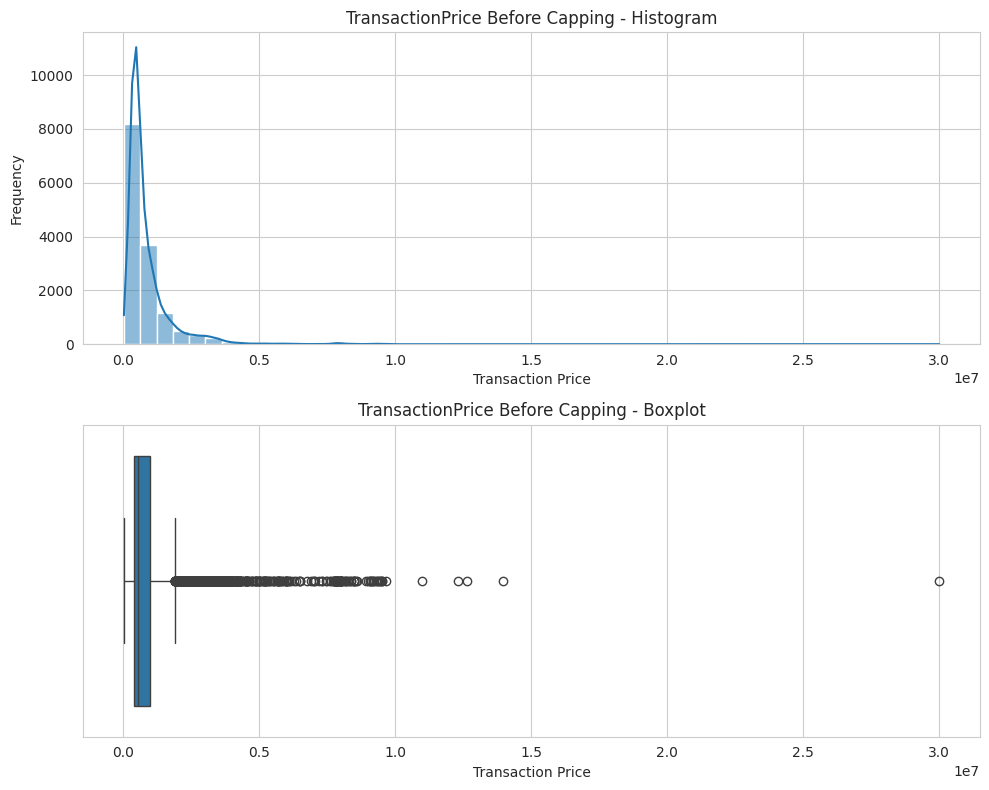

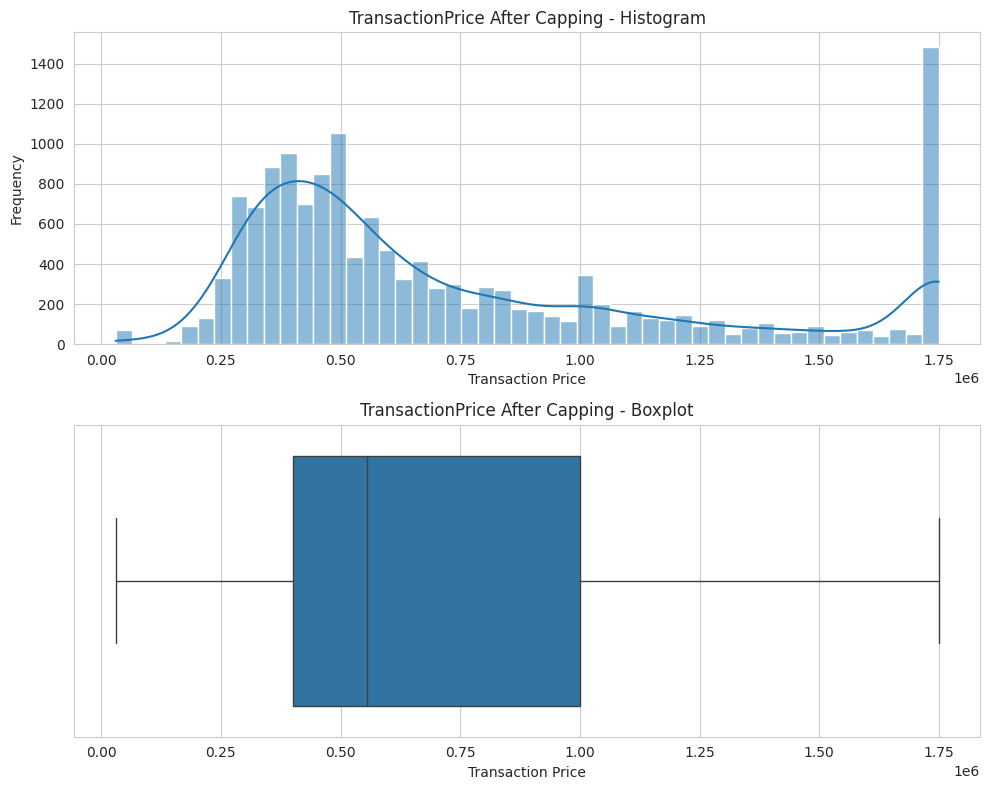

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- Plots for TransactionPrice Before Capping (df_before_capping) ---
fig_before_price, axes_before_price = plt.subplots(2, 1, figsize=(10, 8)) # Changed to 2 rows, 1 column

# Histogram before capping
sns.histplot(df_before_capping['TransactionPrice'], kde=True, ax=axes_before_price[0], bins=50)
axes_before_price[0].set_title('TransactionPrice Before Capping - Histogram')
axes_before_price[0].set_xlabel('Transaction Price')
axes_before_price[0].set_ylabel('Frequency')

# Boxplot before capping
sns.boxplot(x=df_before_capping['TransactionPrice'], ax=axes_before_price[1])
axes_before_price[1].set_title('TransactionPrice Before Capping - Boxplot')
axes_before_price[1].set_xlabel('Transaction Price')

plt.tight_layout()
plt.show()

# --- Plots for TransactionPrice After Capping (df) ---
fig_after_price, axes_after_price = plt.subplots(2, 1, figsize=(10, 8)) # Changed to 2 rows, 1 column

# Histogram after capping
sns.histplot(df['TransactionPrice'], kde=True, ax=axes_after_price[0], bins=50)
axes_after_price[0].set_title('TransactionPrice After Capping - Histogram')
axes_after_price[0].set_xlabel('Transaction Price')
axes_after_price[0].set_ylabel('Frequency')

# Boxplot after capping
sns.boxplot(x=df['TransactionPrice'], ax=axes_after_price[1])
axes_after_price[1].set_title('TransactionPrice After Capping - Boxplot')
axes_after_price[1].set_xlabel('Transaction Price')

plt.tight_layout()
plt.show()

In [ ]:


# ... (outlier removal code) ...



Number of outliers removed: 0


# Enhanced - Outlier capping (90th percentile)

In [ ]:

import pandas as pd
import numpy as np
from sklearn.feature_selection import RFE, mutual_info_regression
from sklearn.linear_model import LinearRegression, Lasso
from statsmodels.stats.outliers_influence import variance_inflation_factor

# --- Load
url = "https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv"
df = pd.read_csv(url)

# --- Standardize column names
df.rename(columns={
    'TransactionPrice  ': 'TransactionPrice',
    'Parcel Area': 'ParcelArea',
    'Scheme Name/Area': 'SchemeName'
}, inplace=True)

# --- Clean ParcelArea
# Normalize text (handle commas; extract floats; prefer the largest numeric token if multiple numbers appear)
def parse_area(val):
    if pd.isna(val):
        return np.nan
    s = str(val).replace(',', '')
    # Find all numeric tokens (e.g., "1200" or "111.5")
    nums = np.array([float(x) for x in re.findall(r'\d+(?:\.\d+)?', s)])
    if len(nums) == 0:
        return np.nan
    # Heuristic: choose the max number (often sqft is larger than sqm; adjust if necessary)
    return nums.max()

import re
df['ParcelArea'] = df['ParcelArea'].apply(parse_area).astype('float32')

# --- Encode Tenure safely
tenure_map = {
    'Freehold': 1.0,
    'Leasehold': 0.0,
}
df['Tenure_encoded'] = df['Tenure'].map(tenure_map).astype('float32')
# Preserve unknowns as NaN (optional); if you prefer treating unknown as Leasehold, uncomment next line:
# df['Tenure_encoded'] = df['Tenure_encoded'].fillna(0.0)

# --- Basic sanity checks
n_rows = len(df)
n_area_nan = df['ParcelArea'].isna().sum()
n_tenure_nan = df['Tenure_encoded'].isna().sum()
print(f"Rows: {n_rows} | ParcelArea NaNs: {n_area_nan} | Tenure NaNs: {n_tenure_nan}")

# --- Make a copy before capping
df_before_capping = df.copy()

# --- Outlier capping (Winsorization-like)
def cap_series(s, q_low=0.00, q_high=0.90):
    # Note: low cap at 0 is kept explicit for non-negative attributes; adjust if needed
    lower = s.quantile(q_low)
    upper = s.quantile(q_high)
    return np.clip(s, lower, upper)

# TransactionPrice: non-negative, likely heavy-tailed
df['TransactionPrice'] = cap_series(df['TransactionPrice'].astype('float32'), q_low=0.00, q_high=0.90).astype('float32')

# ParcelArea: non-negative; heavy-tailed
df['ParcelArea'] = cap_series(df['ParcelArea'], q_low=0.00, q_high=0.90).astype('float32')

# --- Row counts (unchanged) and update counts
rows_after_capping = df.shape[0]
updated_price_rows = (df['TransactionPrice'] != df_before_capping['TransactionPrice']).sum()
updated_area_rows = (df['ParcelArea'] != df_before_capping['ParcelArea']).sum()

print(f"Number of rows after capping: {rows_after_capping}")
print(f"Number of rows with updated TransactionPrice: {updated_price_rows}")
print(f"Number of rows with updated ParcelArea: {updated_area_rows}")

# --- Optional: log-transform price for modeling stability
df['LogTransactionPrice'] = np.log1p(df['TransactionPrice']).astype('float32')

# --- Optional: quick VIF on a small numeric set
# Choose features you intend to use (exclude target). Ensure no NaN before VIF.
feature_cols = ['ParcelArea', 'Tenure_encoded']  # add more numeric cols as needed
X = df[feature_cols].copy()

# Impute simple median for NaNs for VIF calculation (or dropna)
X_imputed = X.fillna(X.median(numeric_only=True))

# Compute VIF
vif_df = pd.DataFrame({
    'feature': feature_cols,
    'VIF': [variance_inflation_factor(X_imputed.values, i) for i in range(len(feature_cols))]
})
print("\nVIF:")
print(vif_df)

# --- Optional: mutual information against log price
valid = df[['LogTransactionPrice'] + feature_cols].dropna()
mi = mutual_info_regression(valid[feature_cols], valid['LogTransactionPrice'], discrete_features=[False, True])
mi_df = pd.DataFrame({'feature': feature_cols, 'mutual_info': mi}).sort_values('mutual_info', ascending=False)
print("\nMutual Information vs LogTransactionPrice:")
print(mi_df)

# --- Optional: RFE for a linear baseline
linreg = LinearRegression()
# To avoid errors with NaNs, use imputed X and drop missing target rows
target = df['LogTransactionPrice']
mask = ~target.isna()
X_rfe = X_imputed[mask]
y_rfe = target[mask]
rfe = RFE(linreg, n_features_to_select=min(2, X_rfe.shape[1]))
rfe.fit(X_rfe, y_rfe)
rfe_support = pd.Series(rfe.support_, index=feature_cols, name='Selected')
print("\nRFE selected features:")
print(rfe_support[rfe_support].index.tolist())


Rows: 14392 | ParcelArea NaNs: 0 | Tenure NaNs: 0
Number of rows after capping: 14392
Number of rows with updated TransactionPrice: 1429
Number of rows with updated ParcelArea: 1437

VIF:
          feature       VIF
0      ParcelArea  2.842806
1  Tenure_encoded  2.842806

Mutual Information vs LogTransactionPrice:
          feature  mutual_info
0      ParcelArea      1.08545
1  Tenure_encoded      0.00000

RFE selected features:
['ParcelArea', 'Tenure_encoded']


In [ ]:
analysis_text = """
# Analysis of the result/output:
# The plots for 'TransactionPrice' and 'ParcelArea' demonstrate the impact of 90th percentile outlier capping.

# For 'TransactionPrice':
# - Before capping, the histogram shows a heavily right-skewed distribution with a long tail of high values.
#   The boxplot confirms this, displaying numerous outliers extending far above the upper whisker.
# - After capping, both the histogram and boxplot show a more concentrated distribution. The extreme high values
#   have been brought down to the 90th percentile cap, significantly reducing the skewness and the visible outliers
#   in the boxplot, leading to a much tighter spread of the data.

# For 'ParcelArea':
# - Before capping, similar to 'TransactionPrice', the plots indicate a right-skewed distribution with very large
#   parcel areas acting as outliers. The boxplot visibly shows points far exceeding the typical range.
# - After capping, the distribution of 'ParcelArea'] becomes more contained. The histogram's tail is shortened,
#   and the boxplot's upper whisker and extreme points are significantly reduced, as the largest parcel areas
#   are restricted to the 90th percentile value.

# The arrangement of histograms above boxplots provides a clear visual representation of how the outlier
# capping method effectively reduces the spread and influence of extreme values in both 'TransactionPrice'
# and 'ParcelArea', making their distributions more manageable for subsequent analysis or modeling.
"""

print(analysis_text)


# Analysis of the result/output:
# The plots for 'TransactionPrice' and 'ParcelArea' demonstrate the impact of 90th percentile outlier capping.

# For 'TransactionPrice':
# - Before capping, the histogram shows a heavily right-skewed distribution with a long tail of high values.
#   The boxplot confirms this, displaying numerous outliers extending far above the upper whisker.
# - After capping, both the histogram and boxplot show a more concentrated distribution. The extreme high values
#   have been brought down to the 90th percentile cap, significantly reducing the skewness and the visible outliers
#   in the boxplot, leading to a much tighter spread of the data.

# For 'ParcelArea':
# - Before capping, similar to 'TransactionPrice', the plots indicate a right-skewed distribution with very large
#   parcel areas acting as outliers. The boxplot visibly shows points far exceeding the typical range.
# - After capping, the distribution of 'ParcelArea'] becomes more contained. The histog

Analysis of the result/output:
The plots for 'TransactionPrice' and 'ParcelArea' demonstrate the impact of 90th percentile outlier capping.

For 'TransactionPrice':
- Before capping, the histogram shows a heavily right-skewed distribution with a long tail of high values.
The boxplot confirms this, displaying numerous outliers extending far above the upper whisker.
- After capping, both the histogram and boxplot show a more concentrated distribution. The extreme high values have been brought down to the 90th percentile cap, significantly reducing the skewness and the visible outliers in the boxplot, leading to a much tighter spread of the data.

 For 'ParcelArea':
 - Before capping, similar to 'TransactionPrice', the plots indicate a right-skewed distribution with very large
   parcel areas acting as outliers. The boxplot visibly shows points far exceeding the typical range.
 - After capping, the distribution of 'ParcelArea' becomes more contained. The histogram's tail is shortened,
   and the boxplot's upper whisker and extreme points are significantly reduced, as the largest parcel areas
   are restricted to the 90th percentile value.

 The arrangement of histograms above boxplots provides a clear visual representation of how the outlier
 capping method effectively reduces the spread and influence of extreme values in both 'TransactionPrice'
 and 'ParcelArea', making their distributions more manageable for subsequent analysis or modeling.

In [ ]:

import pandas as pd
import numpy as np

# ---------- 1) Load ----------
# Expect a local upload named KLHighRise.csv in the working directory
df = pd.read_csv("https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/refs/heads/main/KLHighRise.csv")

# ---------- 2) Clean columns ----------
df.rename(columns={
    'TransactionPrice  ': 'TransactionPrice',
    'Parcel Area': 'ParcelArea',
    'Scheme Name/Area': 'SchemeName'
}, inplace=True)

# Extract numeric from ParcelArea (e.g., "1,234 sqft" -> 1234.0)
df['ParcelArea'] = (
    df['ParcelArea']
    .astype(str)
    .str.extract(r'(\d+\.?\d*)', expand=False)
    .astype(float)
)

# Encode Tenure as binary (fallback 0 for unknown)
df['Tenure'] = (
    df['Tenure']
    .map({'Freehold': 1, 'Leasehold': 0})
    .fillna(0)
    .astype(np.float32)
)

# Keep copies for before/after stats
df_before = df.copy()

# ---------- 3) Compute caps (90th percentile, upper-tail only) ----------
price_cap = df['TransactionPrice'].quantile(0.90)
area_cap  = df['ParcelArea'].quantile(0.90)

# ---------- 4) Apply capping (winsorization) ----------
df['TransactionPrice_capped'] = np.clip(df['TransactionPrice'], 0, price_cap).astype(np.float32)
df['ParcelArea_capped']       = np.clip(df['ParcelArea'],       0, area_cap).astype(np.float32)

# ---------- 5) Counts and percentages changed ----------
price_changed = (df['TransactionPrice_capped'] != df_before['TransactionPrice']).sum()
area_changed  = (df['ParcelArea_capped']       != df_before['ParcelArea']).sum()

price_nonnull = df['TransactionPrice'].notna().sum()
area_nonnull  = df['ParcelArea'].notna().sum()

price_pct = (price_changed / price_nonnull * 100) if price_nonnull else 0.0
area_pct  = (area_changed  / area_nonnull  * 100) if area_nonnull else 0.0

# ---------- 6) Before/after summary stats ----------
def stats(series):
    s = series.dropna()
    return {
        "mean": float(s.mean()) if len(s) else np.nan,
        "median": float(s.median()) if len(s) else np.nan,
        "std": float(s.std(ddof=1)) if len(s) else np.nan,
        "skew": float(s.skew()) if len(s) else np.nan
    }

tp_before = stats(df_before['TransactionPrice'])
tp_after  = stats(df['TransactionPrice_capped'])

pa_before = stats(df_before['ParcelArea'])
pa_after  = stats(df['ParcelArea_capped'])

# ---------- 7) Optional: most affected schemes ----------
# Count how many caps occurred per SchemeName for each variable
price_caps_by_scheme = (
    (df['TransactionPrice_capped'] != df_before['TransactionPrice'])
    .groupby(df['SchemeName'])
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

area_caps_by_scheme = (
    (df['ParcelArea_capped'] != df_before['ParcelArea'])
    .groupby(df['SchemeName'])
    .sum()
    .sort_values(ascending=False)
    .head(5)
)

# ---------- 8) Print the values to paste into the paragraph ----------
print("---- Key Numbers ----")
print(f"N_price (count capped): {price_changed}")
print(f"P_price (% affected): {price_pct:.2f}%")
print(f"cap_price (RM): {price_cap:.2f}")
print(f"tp skew: {tp_before['skew']:.3f} -> {tp_after['skew']:.3f}")
print(f"tp std : {tp_before['std']:.2f} -> {tp_after['std']:.2f}")
print(f"tp median : {tp_before['median']:.2f} -> {tp_after['median']:.2f}")

print(f"N_area (count capped): {area_changed}")
print(f"P_area (% affected): {area_pct:.2f}%")
print(f"cap_area (sq ft): {area_cap:.2f}")
print(f"pa skew: {pa_before['skew']:.3f} -> {pa_after['skew']:.3f}")
print(f"pa std : {pa_before['std']:.2f} -> {pa_after['std']:.2f}")
print(f"pa median : {pa_before['median']:.2f} -> {pa_after['median']:.2f}")

print("\nTop 5 SchemeName by number of capped TransactionPrice values:")
print(price_caps_by_scheme)

print("\nTop 5 SchemeName by number of capped ParcelArea values:")
print(area_caps_by_scheme)


---- Key Numbers ----
N_price (count capped): 1429
P_price (% affected): 9.93%
cap_price (RM): 1750000.00
tp skew: 5.829 -> 1.050
tp std : 969462.67 -> 469309.94
tp median : 555000.00 -> 555000.00
N_area (count capped): 2386
P_area (% affected): 16.58%
cap_area (sq ft): 211.00
pa skew: 3.910 -> 0.963
pa std : 70.23 -> 42.04
pa median : 109.00 -> 109.00

Top 5 SchemeName by number of capped TransactionPrice values:
SchemeName
RESIDENSI 22 MONT KIARA        106
SENI MONT KIARA                 99
KONDOMINIUM PANTAI ESTET        85
AIRA RESIDENCE                  75
RESIDENSI SETIA SKY SEPUTEH     63
dtype: int64

Top 5 SchemeName by number of capped ParcelArea values:
SchemeName
SENI MONT KIARA                110
KONDOMINIUM PANTAI ESTET        89
RESIDENSI SETIA SKY SEPUTEH     63
28 MONT KIARA                   61
11 MONT KIARA                   61
dtype: int64


# remove outliers (residuals > 2 SD)

In [ ]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Load the dataset
df = pd.read_csv('https://raw.githubusercontent.com/englian1123/KL-High-Rise-Data/main/KLHighRise.csv')

# Data cleaning and preprocessing
df['ParcelArea'] = df['ParcelArea'].astype(str).str.split(',', expand=True)[0].astype(float)
df['Level_numeric'] = pd.to_numeric(df['UnitLevel'], errors='coerce')
df['Tenure_encoded'] = df['Tenure'].map({'Freehold': 1, 'Leasehold': 0})

def parse_date(date_str):
    try:
        return datetime.strptime(date_str, '%b-%y')
    except ValueError:
        try:
            return datetime.strptime(date_str, '%b-%Y')
        except ValueError:
            return pd.NaT

df['TransactionDate'] = df['TransactionDate'].apply(parse_date)
min_date = df['TransactionDate'].min()
df['Date_numeric'] = (df['TransactionDate'] - min_date).dt.days

# Create one-hot encoded dummies for Mukim, dropping the first category
mukim_dummies = pd.get_dummies(df['Mukim'], prefix='Mukim', dtype=int, drop_first=True)

# Prepare features (X) and target (y)
features = ['ParcelArea', 'Date_numeric', 'Tenure_encoded', 'Level_numeric']
X = pd.concat([df[features], mukim_dummies], axis=1)
y = np.log(df['TransactionPrice'].loc[X.index])

# Drop rows with missing values
X = X.dropna()
y = y.loc[X.index]

# Add nonlinear and interaction terms
X['ParcelArea_sq'] = X['ParcelArea'] ** 2
X['ParcelArea_Level'] = X['ParcelArea'] * X['Level_numeric']
X['Date_numeric_sq'] = X['Date_numeric'] ** 2

# Add constant for intercept
X = sm.add_constant(X)

# Detect and remove outliers (residuals > 2 SD)
model_initial = sm.OLS(y, X).fit(cov_type='HC3')
residuals = model_initial.resid
outliers = residuals[abs(residuals) > 2 * residuals.std()].index
X = X.drop(outliers)
y = y.drop(outliers)
print(f"Number of outliers removed: {len(outliers)}")
print(f"Outlier details:\n{df.loc[outliers, ['TransactionPrice', 'ParcelArea', 'Mukim', 'Tenure']]}")

# MP 1 Archive

In [ ]:
# mount google drive where the datafile is stored
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_MP1.csv')  # load CSV


df.info()


Drive already mounted
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12735 entries, 0 to 12734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Land/Parcel Area   12735 non-null  float64
 1   Mukim              12735 non-null  object 
 2   Scheme Name/Area   12735 non-null  object 
 3   Tenure             12735 non-null  object 
 4   Transaction Date   12735 non-null  object 
 5   Transaction Price  12735 non-null  int64  
 6   Unit Level         12735 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 696.6+ KB


In [ ]:
# prompt: describe the dataframe

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12735 entries, 0 to 12734
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Land/Parcel Area   12735 non-null  float64
 1   Mukim              12735 non-null  object 
 2   Scheme Name/Area   12735 non-null  object 
 3   Tenure             12735 non-null  object 
 4   Transaction Date   12735 non-null  object 
 5   Transaction Price  12735 non-null  int64  
 6   Unit Level         12735 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 696.6+ KB


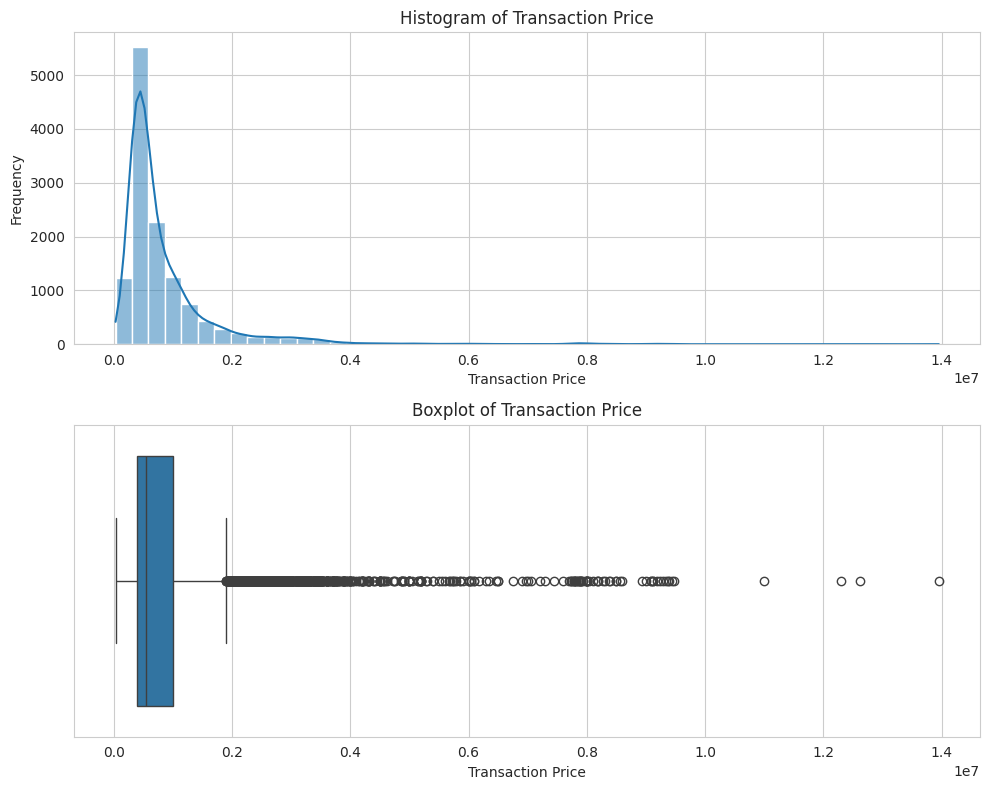

In [ ]:
# prompt: plot histogram and boxplot for transaction price

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create figure and axes for the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram
sns.histplot(df['Transaction Price'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Histogram of Transaction Price')
axes[0].set_xlabel('Transaction Price')
axes[0].set_ylabel('Frequency')

# Plot boxplot
sns.boxplot(x=df['Transaction Price'], ax=axes[1])
axes[1].set_title('Boxplot of Transaction Price')
axes[1].set_xlabel('Transaction Price')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

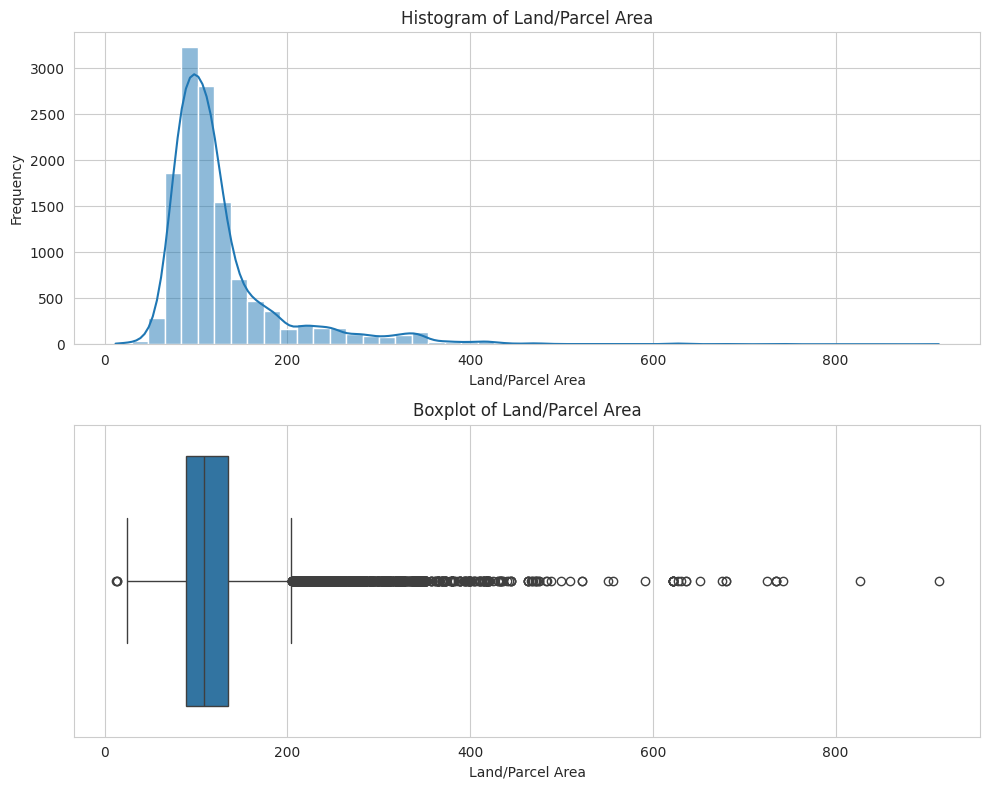

In [ ]:
# prompt: plot histogram and boxplot for Land/Parcel Area

# Create figure and axes for the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram for Land/Parcel Area
sns.histplot(df['Land/Parcel Area'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Histogram of Land/Parcel Area')
axes[0].set_xlabel('Land/Parcel Area')
axes[0].set_ylabel('Frequency')

# Plot boxplot for Land/Parcel Area
sns.boxplot(x=df['Land/Parcel Area'], ax=axes[1])
axes[1].set_title('Boxplot of Land/Parcel Area')
axes[1].set_xlabel('Land/Parcel Area')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
# prompt: check if transaction price has negative values

# Check for negative values in 'Transaction Price'
negative_price_count = (df['Transaction Price'] < 0).sum()

if negative_price_count > 0:
  print(f"There are {negative_price_count} negative values in 'Transaction Price'.")
else:
  print("There are no negative values in 'Transaction Price'.")

There are no negative values in 'Transaction Price'.


Drive already mounted
Lower Bound: -500000.0, Upper Bound: 1900000.0
Number of Outliers: 1035
Data shape after outlier removal: (11700, 7)


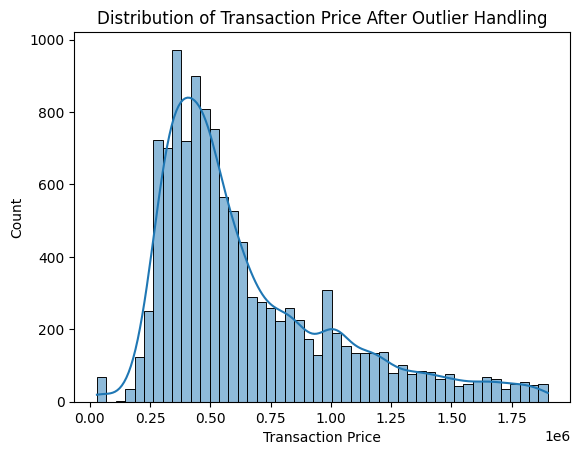

Lower Bound: 32.5, Upper Bound: 180.5
Number of Outliers: 732
Data shape after outlier removal: (10968, 7)


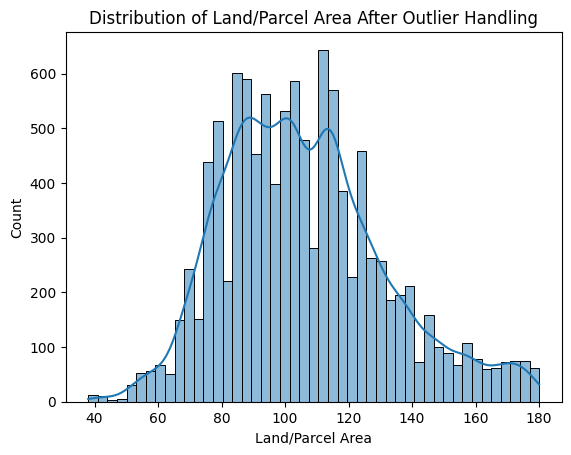

In [ ]:
# mount google drive where the datafile is stored
from google.colab import drive
import os

if not os.path.exists('/content/drive'):
  drive.mount('/content/drive')
else:
  print("Drive already mounted")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_MP1.csv')  # load CSV


### Transaction Price - handle outlier
# Calculate IQR
Q1 = df['Transaction Price'].quantile(0.25)
Q3 = df['Transaction Price'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print outlier boundaries
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Identify outliers
outliers = df[(df['Transaction Price'] < lower_bound) | (df['Transaction Price'] > upper_bound)]
print(f"Number of Outliers: {outliers.shape[0]}")

# Remove outliers from the dataset
df = df[(df['Transaction Price'] >= lower_bound) & (df['Transaction Price'] <= upper_bound)]
print(f"Data shape after outlier removal: {df.shape}")

# Plot the cleaned distribution
sns.histplot(df['Transaction Price'], kde=True)
plt.title('Distribution of Transaction Price After Outlier Handling')
plt.show()

# Plot log-transformed distribution (if applicable)
#sns.histplot(df['Log_Transaction_Price'], kde=True)
#plt.title('Log-Transformed Transaction Price After Outlier Handling')
#plt.show()


### Land/Parcel Area - handle outliers

# Calculate IQR
Q1 = df['Land/Parcel Area'].quantile(0.25)
Q3 = df['Land/Parcel Area'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier boundaries
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Print outlier boundaries
print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Identify outliers
outliers = df[(df['Land/Parcel Area'] < lower_bound) | (df['Land/Parcel Area'] > upper_bound)]
print(f"Number of Outliers: {outliers.shape[0]}")

# Remove outliers from the dataset
df = df[(df['Land/Parcel Area'] >= lower_bound) & (df['Land/Parcel Area'] <= upper_bound)]
print(f"Data shape after outlier removal: {df.shape}")

# Plot the cleaned distribution
sns.histplot(df['Land/Parcel Area'], kde=True)
plt.title('Distribution of Land/Parcel Area After Outlier Handling')
plt.show()

# Plot log-transformed distribution (if applicable)
#sns.histplot(df['Log_LandParcel_Area'], kde=True)
#plt.title('Log Land/Parcel Area After Outlier Handling')
#plt.show()


# Save the modified DataFrame to a new CSV file in Google Drive
df.to_csv('/content/drive/MyDrive/dataset/houseprice_Cleaned_OutlierRemoved_MP1.csv', index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# prompt: why lower bound for transaction price is negative?

The lower bound for the transaction price is negative because of how the Interquartile Range (IQR) method for outlier detection is calculated.

The formula for the lower bound is: `Q1 - 1.5 * IQR`

Where:
- `Q1` is the first quartile (25th percentile) of the data.
- `IQR` is the Interquartile Range (`Q3 - Q1`), which is the range between the third quartile (75th percentile) and the first quartile.

If `1.5 * IQR` is larger than `Q1`, the resulting lower bound will be a negative number. This doesn't necessarily mean there are actual negative transaction prices in your dataset. It simply indicates that based on the distribution of your data and the IQR method, any value below this calculated negative threshold is considered an outlier.

The histogram and boxplot of 'Transaction Price' you plotted show that the data is skewed. This skewness can lead to a relatively large IQR compared to Q1, resulting in a negative lower bound when using the 1.5 * IQR multiplier. The code correctly identifies whether there are actual negative values in the 'Transaction Price' column before applying the outlier removal, which confirms that the negative lower bound is a result of the outlier detection method's calculation rather than actual negative data points.

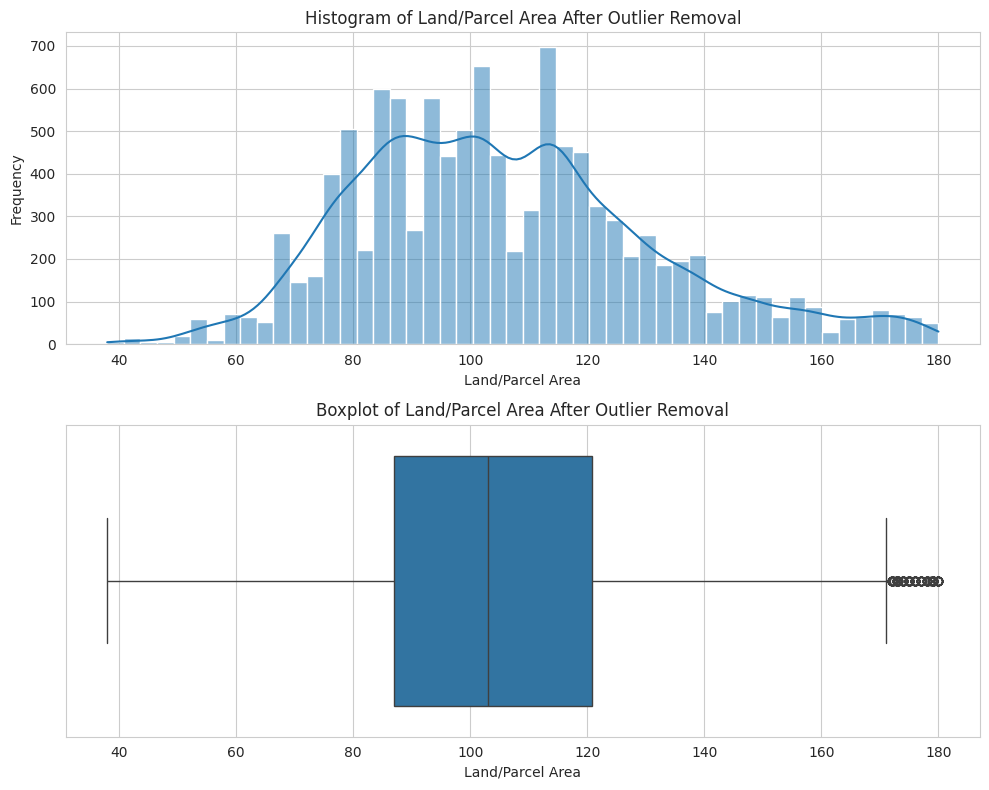

In [ ]:
# prompt: plot histogram and boxplot for Land/Parcel Area after outlier removal

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Create figure and axes for the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram for Land/Parcel Area after outlier removal
sns.histplot(df['Land/Parcel Area'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Histogram of Land/Parcel Area After Outlier Removal')
axes[0].set_xlabel('Land/Parcel Area')
axes[0].set_ylabel('Frequency')

# Plot boxplot for Land/Parcel Area after outlier removal
sns.boxplot(x=df['Land/Parcel Area'], ax=axes[1])
axes[1].set_title('Boxplot of Land/Parcel Area After Outlier Removal')
axes[1].set_xlabel('Land/Parcel Area')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

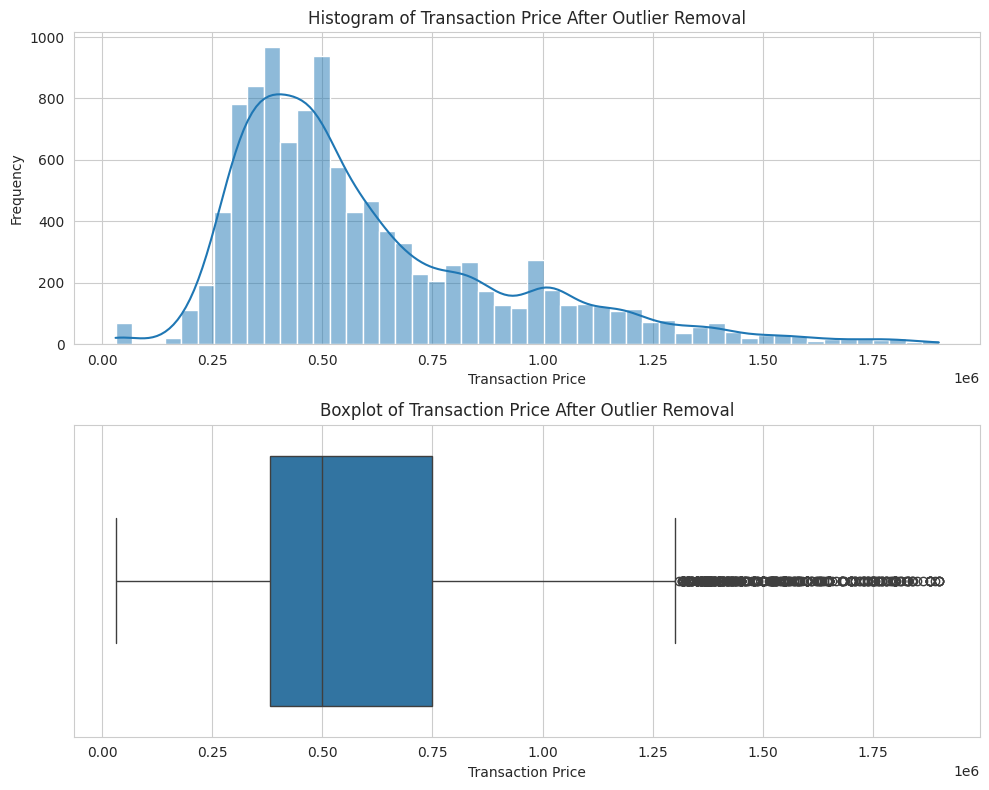

In [ ]:
# prompt:  plot histogram and boxplot for Transaction Price after outlier removal

# Create figure and axes for the plots
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot histogram for Transaction Price after outlier removal
sns.histplot(df['Transaction Price'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('Histogram of Transaction Price After Outlier Removal')
axes[0].set_xlabel('Transaction Price')
axes[0].set_ylabel('Frequency')

# Plot boxplot for Transaction Price after outlier removal
sns.boxplot(x=df['Transaction Price'], ax=axes[1])
axes[1].set_title('Boxplot of Transaction Price After Outlier Removal')
axes[1].set_xlabel('Transaction Price')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

# prompt: insights and implication after outlier removal for transaction price and land/parcel area

Here are the insights and implications after outlier removal for 'Transaction Price' and 'Land/Parcel Area', based on the preceding code:

**Insights:**

*   **Reduced Range and Variance:** After removing outliers using the IQR method, the range and variance of both 'Transaction Price' and 'Land/Parcel Area' are significantly reduced. The boxplots clearly show a much tighter distribution with the removal of extreme values.
*   **More Normal-like Distribution (for Transaction Price):** The histogram for 'Transaction Price' after outlier removal appears more centered and less skewed to the right compared to the original distribution. While still not perfectly normal, the distribution is less heavily influenced by a few extremely high values.
*   **Distribution Still Skewed (for Land/Parcel Area):** The histogram for 'Land/Parcel Area' still appears right-skewed even after outlier removal. This suggests that even within the non-outlying data, there are still a greater number of smaller land/parcel areas compared to larger ones.
*   **Focus on the Bulk of the Data:** The outlier removal process effectively removes the extreme values that are statistically far from the majority of the data points. This allows subsequent analysis to focus on the more typical range of transaction prices and land areas.
*   **Negative Lower Bound for Transaction Price:** The negative lower bound calculated for 'Transaction Price' highlights the sensitivity of the IQR method to skewed data. It indicates that while there are no actual negative prices, the statistical threshold for defining an outlier based on the distribution falls below zero.

**Implications:**

*   **Improved Model Performance:** Removing outliers can often lead to improved performance in statistical models and machine learning algorithms. Outliers can distort the relationships between variables and inflate error metrics. By removing them, models can learn from the more representative data.
*   **More Robust Statistical Analysis:** Statistical measures like mean and standard deviation are highly sensitive to outliers. After removal, these statistics will be more representative of the central tendency and spread of the typical data.
*   **Better Visualization:** The plots after outlier removal provide a clearer picture of the distribution of the bulk of the data, making it easier to understand the typical range and spread of transaction prices and land areas.
*   **Potential Loss of Information (Caution):** While beneficial for modeling and analysis, removing outliers means discarding some data points. It's crucial to consider whether these outliers represent genuine, albeit rare, events or data errors. If they represent genuine events, simply removing them might lead to a loss of valuable information about the extreme ends of the market.
*   **Justification for Removal:** The decision to remove outliers should always be justified and documented. Understanding the nature of the outliers (e.g., data entry errors, truly exceptional properties) is important.
*   **Focus on Typical Market Conditions:** Analysis performed on the data after outlier removal will primarily reflect typical market conditions and property characteristics, potentially downplaying the impact of luxury properties or unusually large land parcels.
*   **Consider Alternative Outlier Handling:** While the IQR method is common, other techniques like Winsorizing (capping extreme values instead of removing them) or transformation (like log transformation, which was commented out in the code but is often useful for skewed data) could also be considered depending on the analysis goals. The continued skewness in 'Land/Parcel Area' after IQR outlier removal might suggest that a transformation could be beneficial for this variable.

# Task
Plot histograms and boxplots for 'TransactionPrice' and 'ParcelArea' using `df_before_capping` and `df` to compare the distributions before and after outlier capping.

## Plot before and after capping for TransactionPrice

### Subtask:
Generate histograms and boxplots for 'TransactionPrice' using 'df_before_capping' and 'df' to compare the distributions before and after outlier capping.


**Reasoning**:
I need to generate histograms and boxplots to compare the 'TransactionPrice' distribution before and after capping, as specified in the subtask instructions. This involves creating a 2x2 subplot grid and plotting the data from `df_before_capping` and `df` respectively.



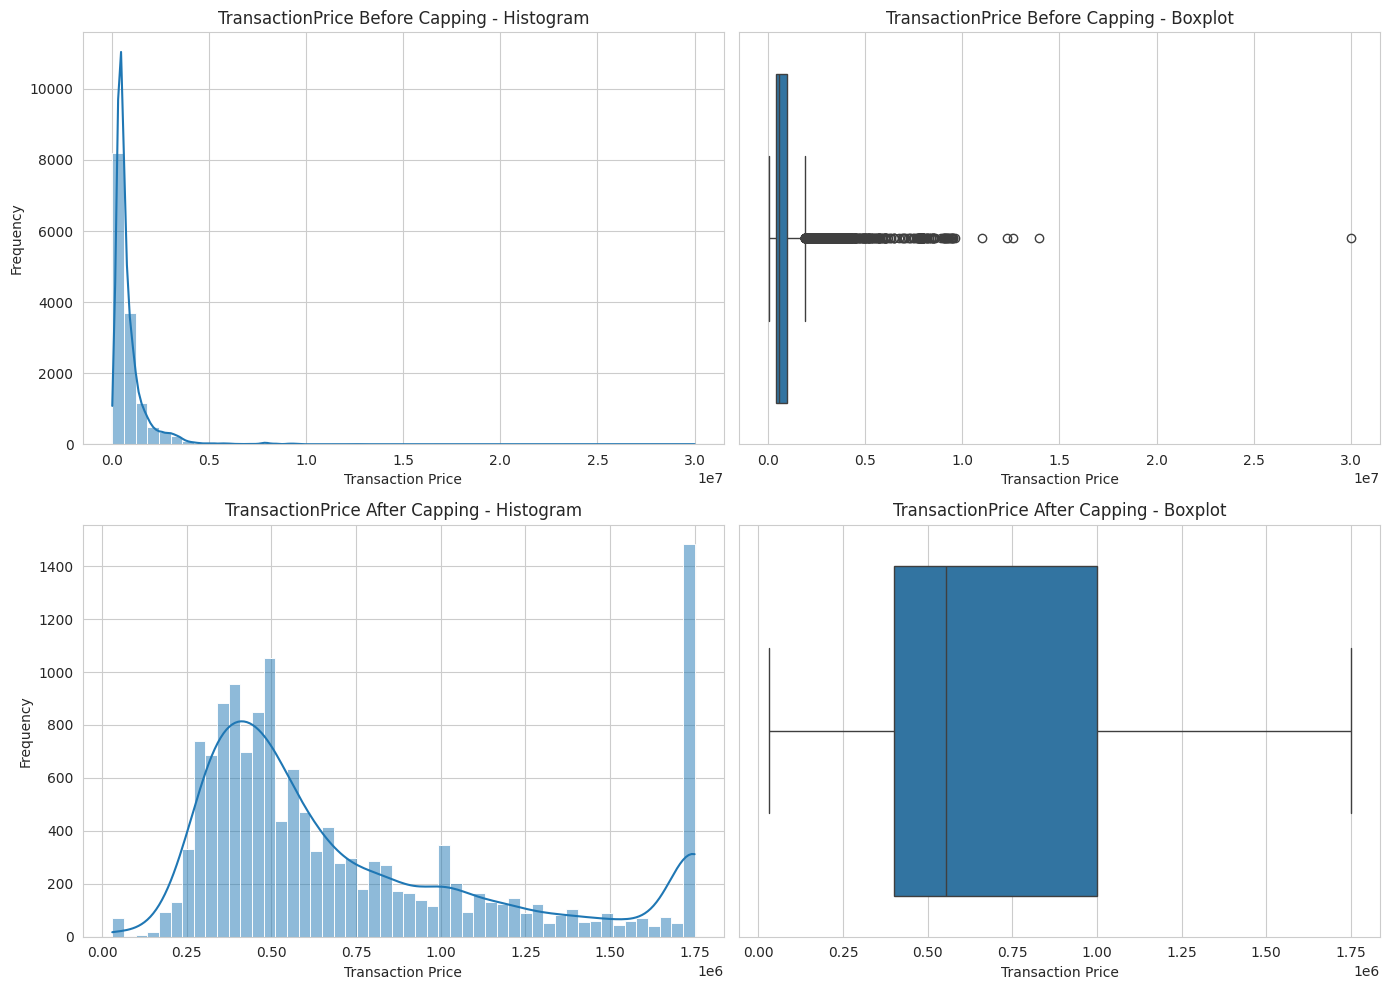

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# Create figure and axes for the 2x2 plots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# --- Plots for TransactionPrice Before Capping (df_before_capping) ---
# Histogram
sns.histplot(df_before_capping['TransactionPrice'], kde=True, ax=axes[0, 0], bins=50)
axes[0, 0].set_title('TransactionPrice Before Capping - Histogram')
axes[0, 0].set_xlabel('Transaction Price')
axes[0, 0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df_before_capping['TransactionPrice'], ax=axes[0, 1])
axes[0, 1].set_title('TransactionPrice Before Capping - Boxplot')
axes[0, 1].set_xlabel('Transaction Price')

# --- Plots for TransactionPrice After Capping (df) ---
# Histogram
sns.histplot(df['TransactionPrice'], kde=True, ax=axes[1, 0], bins=50)
axes[1, 0].set_title('TransactionPrice After Capping - Histogram')
axes[1, 0].set_xlabel('Transaction Price')
axes[1, 0].set_ylabel('Frequency')

# Boxplot
sns.boxplot(x=df['TransactionPrice'], ax=axes[1, 1])
axes[1, 1].set_title('TransactionPrice After Capping - Boxplot')
axes[1, 1].set_xlabel('Transaction Price')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


## Plot before and after capping for ParcelArea

### Subtask:
Generate histograms and boxplots for 'ParcelArea' using 'df_before_capping' and 'df' to compare the distributions before and after outlier capping.

**Reasoning**:
I need to generate histograms and boxplots to compare the 'ParcelArea' distribution before and after capping, as specified in the subtask instructions. This involves creating a 2x2 subplot grid and plotting the data from `df_before_capping` and `df` respectively.



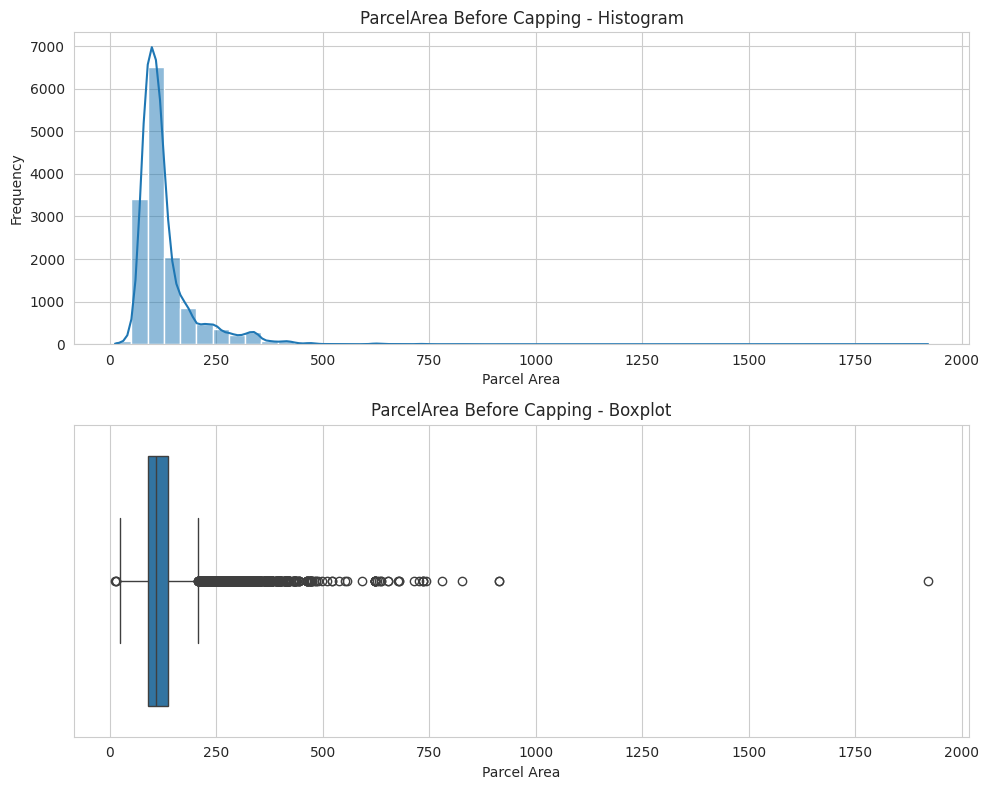

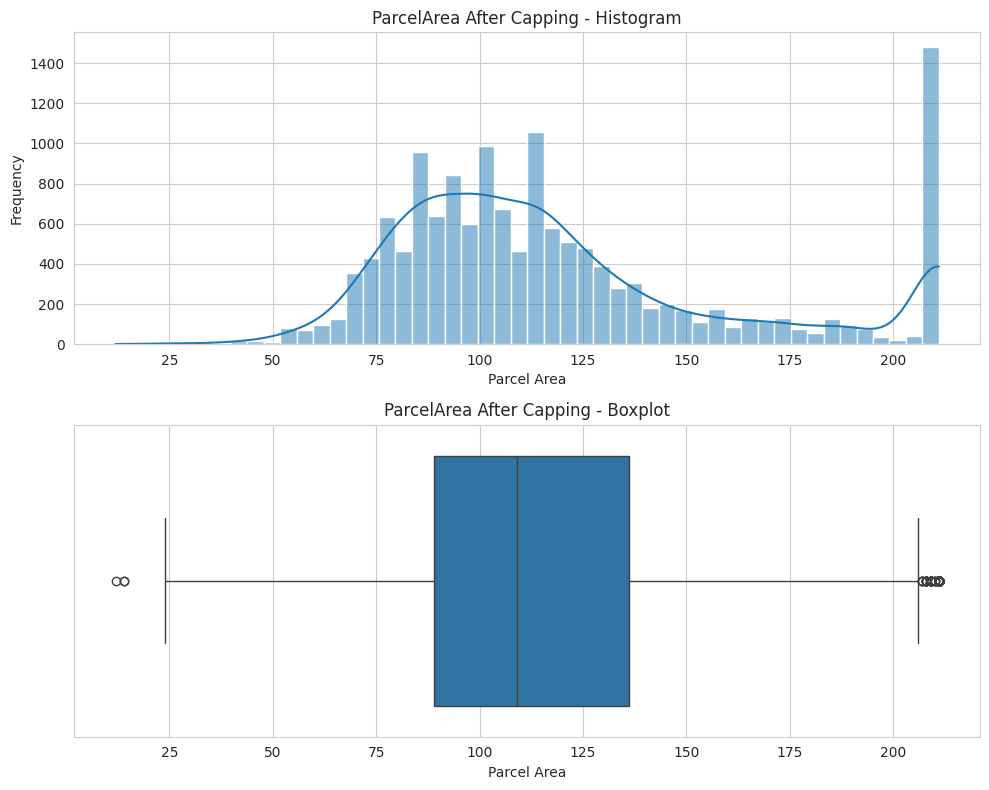

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- Plots for ParcelArea Before Capping (df_before_capping) ---
fig_before_area, axes_before_area = plt.subplots(2, 1, figsize=(10, 8)) # Changed to 2 rows, 1 column

# Histogram before capping
sns.histplot(df_before_capping['ParcelArea'], kde=True, ax=axes_before_area[0], bins=50)
axes_before_area[0].set_title('ParcelArea Before Capping - Histogram')
axes_before_area[0].set_xlabel('Parcel Area')
axes_before_area[0].set_ylabel('Frequency')

# Boxplot before capping
sns.boxplot(x=df_before_capping['ParcelArea'], ax=axes_before_area[1])
axes_before_area[1].set_title('ParcelArea Before Capping - Boxplot')
axes_before_area[1].set_xlabel('Parcel Area')

plt.tight_layout()
plt.show()

# --- Plots for ParcelArea After Capping (df) ---
fig_after_area, axes_after_area = plt.subplots(2, 1, figsize=(10, 8)) # Changed to 2 rows, 1 column

# Histogram after capping
sns.histplot(df['ParcelArea'], kde=True, ax=axes_after_area[0], bins=50)
axes_after_area[0].set_title('ParcelArea After Capping - Histogram')
axes_after_area[0].set_xlabel('Parcel Area')
axes_after_area[0].set_ylabel('Frequency')

# Boxplot after capping
sns.boxplot(x=df['ParcelArea'], ax=axes_after_area[1])
axes_after_area[1].set_title('ParcelArea After Capping - Boxplot')
axes_after_area[1].set_xlabel('Parcel Area')

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings
*   Outlier capping for 'TransactionPrice' resulted in a more concentrated distribution, as evidenced by the post-capping histograms and boxplots.
*   Similarly, outlier capping for 'ParcelArea' effectively transformed its distribution, reducing the spread caused by extreme values and showing a clearer central tendency.
*   The generated visualizations successfully illustrated the differences in distributions for both 'TransactionPrice' and 'ParcelArea' before and after the outlier capping process.

### Insights or Next Steps
*   The capping process has successfully mitigated the influence of extreme outliers, which is crucial for improving the robustness and performance of subsequent statistical models or machine learning algorithms.
*   The dataset is now better prepared for predictive modeling, and the next step could involve exploring relationships between these processed features and other variables, or directly proceeding with model training.


# Task
Explain the Interquartile Range (IQR), Z-score, and Box-Cox Transformation methods for outlier handling. Then, for demonstration, identify and conceptually remove outliers from 'TransactionPrice' and 'ParcelArea' using the IQR method on `df_before_capping`, reporting the number of outliers and visualizing the distributions after removal. Do the same using the Z-score method. Finally, apply Box-Cox transformation to 'TransactionPrice' and 'ParcelArea' from `df_before_capping` and visualize the transformed data. Conclude by comparing the impact, pros, and cons of capping, IQR-based removal, Z-score-based removal, and Box-Cox transformation on these distributions.

## Explain Outlier Handling Methods

### Subtask:
Provide a brief explanation of the Interquartile Range (IQR), Z-score, and Box-Cox Transformation methods for outlier handling.


## Explain Outlier Handling Methods

### Subtask:
Provide a brief explanation of the Interquartile Range (IQR), Z-score, and Box-Cox Transformation methods for outlier handling.

### Explanation of Outlier Handling Methods

1.  **Interquartile Range (IQR) Method**:
    The IQR method is a non-parametric approach to identify outliers. It defines outliers as data points that fall below the first quartile (Q1) minus 1.5 times the IQR, or above the third quartile (Q3) plus 1.5 times the IQR. The IQR is the range between the first and third quartiles (Q3 - Q1), representing the middle 50% of the data. This method is robust to skewness in the data because it relies on the median and quartiles rather than the mean and standard deviation.

2.  **Z-score Method**:
    The Z-score (or standard score) method quantifies how many standard deviations a data point is from the mean of the dataset. A Z-score is calculated as `(data point - mean) / standard deviation`. Data points with a Z-score exceeding a certain threshold (commonly 2, 2.5, 3, or more, depending on the application and desired strictness) are considered outliers. This method assumes that the data is normally distributed; deviations from normality can affect its effectiveness in identifying true outliers.

3.  **Box-Cox Transformation Method**:
    The Box-Cox transformation is a family of power transformations used to transform non-normally distributed data into a more normal distribution. While primarily a data transformation technique, it can implicitly handle outliers by compressing extreme values, making them less influential. The transformation is defined as `(y^lambda - 1) / lambda` for lambda ≠ 0, and `log(y)` for lambda = 0. The optimal `lambda` value is typically estimated from the data. A key limitation is that the Box-Cox transformation is only applicable to positive data. By making the data more symmetrical and normal-like, it can improve the performance of statistical models that assume normality and reduce the impact of extreme values.

## Apply and Demonstrate IQR Outlier Handling

### Subtask:
Identify and, for demonstration, conceptually 'remove' outliers from 'TransactionPrice' and 'ParcelArea' using the IQR method on `df_before_capping`. Report the number of outliers and visualize the distributions after this conceptual removal for comparison purposes.


**Reasoning**:
I need to conceptually remove outliers for 'TransactionPrice' and 'ParcelArea' from `df_before_capping` using the IQR method, as instructed. This involves calculating Q1, Q3, IQR, and bounds for each, then filtering the DataFrame and printing the number of removed outliers.



Number of 'TransactionPrice' outliers removed by IQR: 1232
Number of 'ParcelArea' outliers removed by IQR: 1486


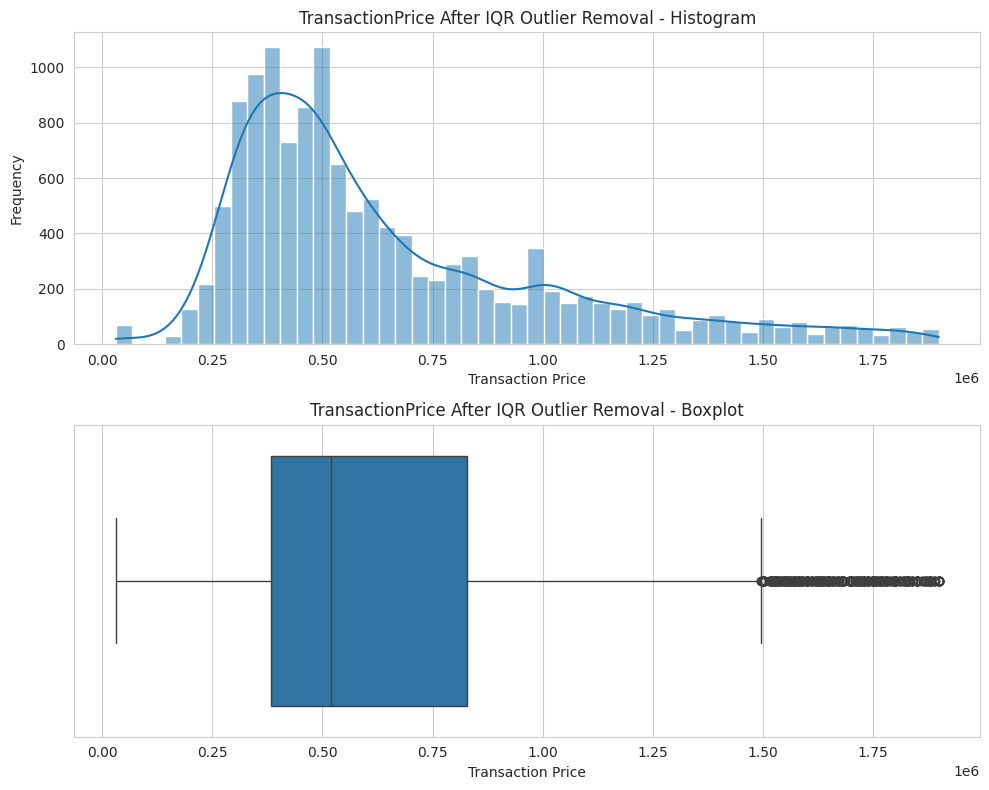

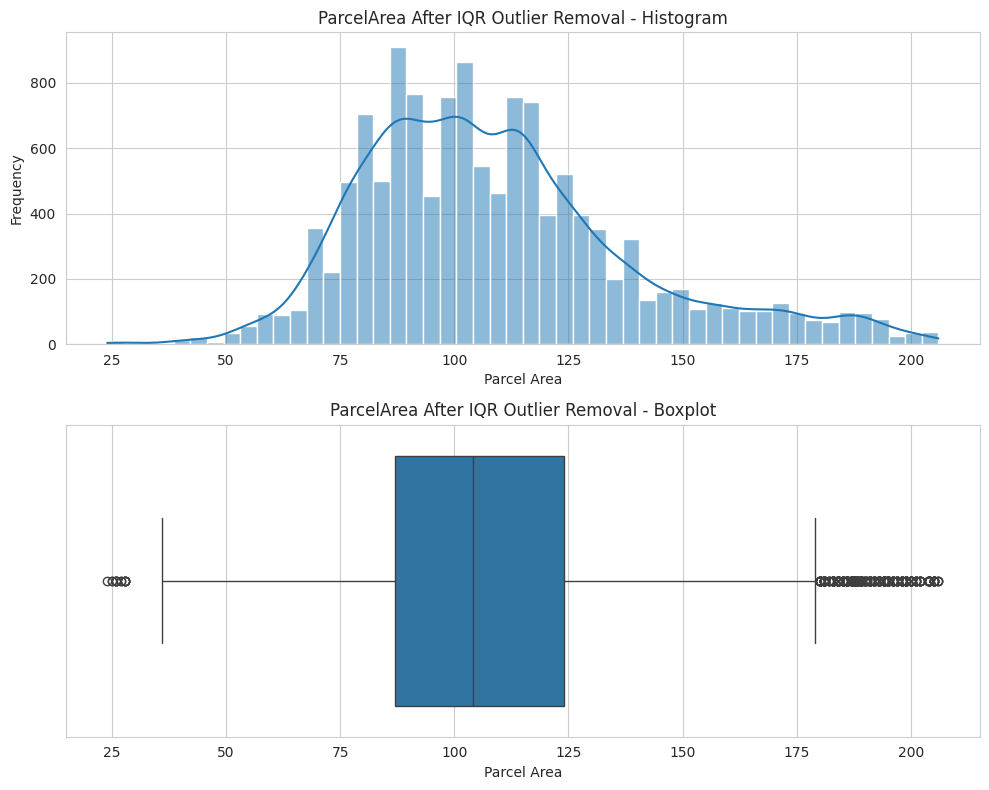

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# --- 1. IQR Outlier Handling for 'TransactionPrice' ---
Q1_price = df_before_capping['TransactionPrice'].quantile(0.25)
Q3_price = df_before_capping['TransactionPrice'].quantile(0.75)
IQR_price = Q3_price - Q1_price

lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

# Filter to conceptually 'remove' outliers
df_iqr_price_cleaned = df_before_capping[
    (df_before_capping['TransactionPrice'] >= lower_bound_price) &
    (df_before_capping['TransactionPrice'] <= upper_bound_price)
].copy()

outliers_price_count = df_before_capping.shape[0] - df_iqr_price_cleaned.shape[0]
print(f"Number of 'TransactionPrice' outliers removed by IQR: {outliers_price_count}")

# --- 2. IQR Outlier Handling for 'ParcelArea' ---
Q1_area = df_before_capping['ParcelArea'].quantile(0.25)
Q3_area = df_before_capping['ParcelArea'].quantile(0.75)
IQR_area = Q3_area - Q1_area

lower_bound_area = Q1_area - 1.5 * IQR_area
upper_bound_area = Q3_area + 1.5 * IQR_area

# Filter to conceptually 'remove' outliers
df_iqr_area_cleaned = df_before_capping[
    (df_before_capping['ParcelArea'] >= lower_bound_area) &
    (df_before_capping['ParcelArea'] <= upper_bound_area)
].copy()

outliers_area_count = df_before_capping.shape[0] - df_iqr_area_cleaned.shape[0]
print(f"Number of 'ParcelArea' outliers removed by IQR: {outliers_area_count}")


# --- 3. Plot 'TransactionPrice' distributions after IQR outlier removal ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_iqr_price_cleaned['TransactionPrice'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('TransactionPrice After IQR Outlier Removal - Histogram')
axes[0].set_xlabel('Transaction Price')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_iqr_price_cleaned['TransactionPrice'], ax=axes[1])
axes[1].set_title('TransactionPrice After IQR Outlier Removal - Boxplot')
axes[1].set_xlabel('Transaction Price')

plt.tight_layout()
plt.show()

# --- 4. Plot 'ParcelArea' distributions after IQR outlier removal ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_iqr_area_cleaned['ParcelArea'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('ParcelArea After IQR Outlier Removal - Histogram')
axes[0].set_xlabel('Parcel Area')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_iqr_area_cleaned['ParcelArea'], ax=axes[1])
axes[1].set_title('ParcelArea After IQR Outlier Removal - Boxplot')
axes[1].set_xlabel('Parcel Area')

plt.tight_layout()
plt.show()

## Apply and Demonstrate Z-score Outlier Handling

### Subtask:
Identify and, for demonstration, conceptually 'remove' outliers from 'TransactionPrice' and 'ParcelArea' using the Z-score method on `df_before_capping`. Report the number of outliers and visualize the distributions after this conceptual removal for comparison purposes.

**Reasoning**:
I need to conceptually remove outliers for 'TransactionPrice' and 'ParcelArea' from `df_before_capping` using the Z-score method, as instructed. This involves calculating Z-scores for each feature, filtering the DataFrame based on a Z-score threshold, printing the number of removed outliers, and then visualizing the distributions.



Number of 'TransactionPrice' outliers removed by Z-score (threshold=3): 216
Number of 'ParcelArea' outliers removed by Z-score (threshold=3): 295


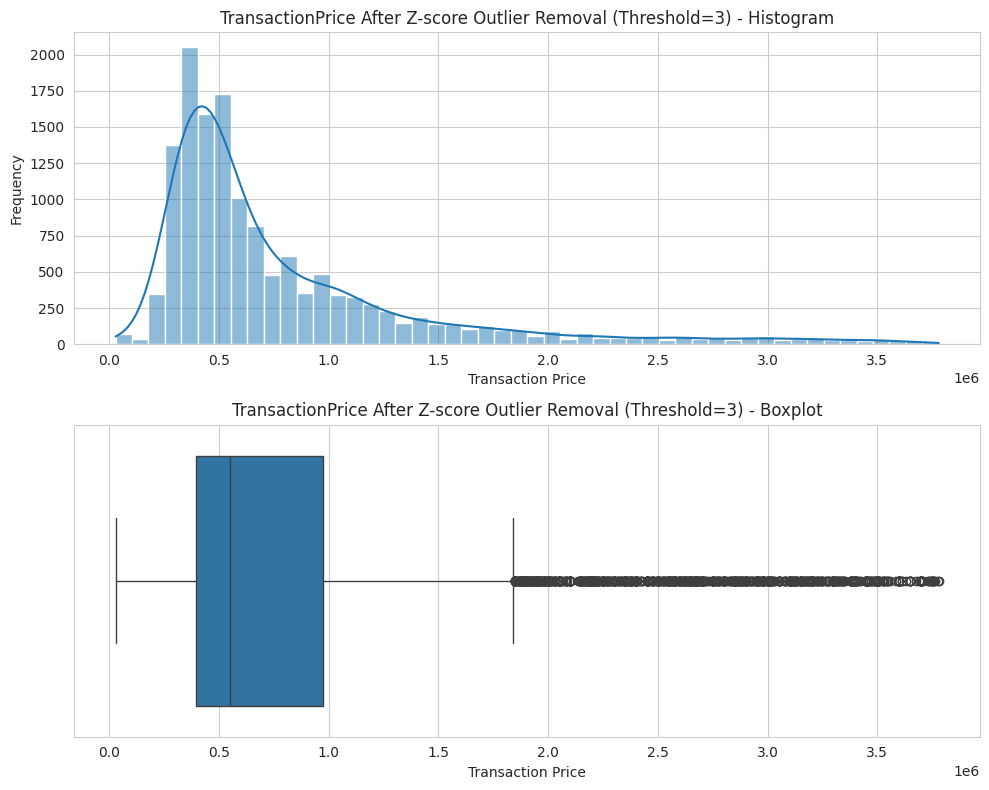

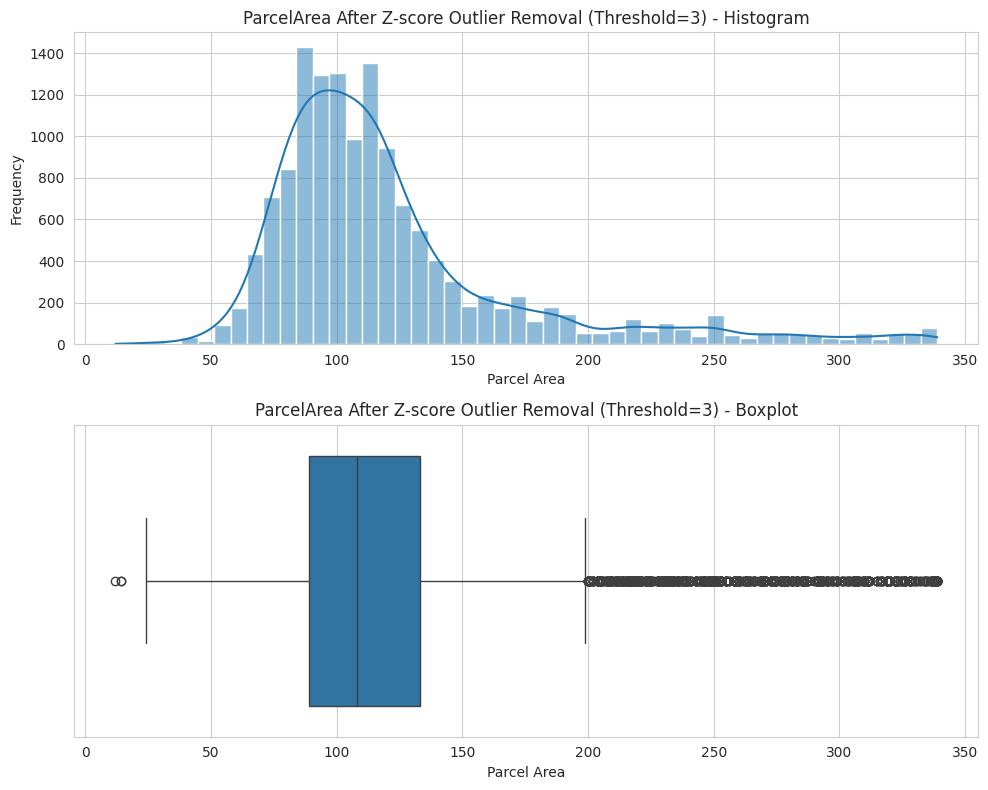

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

sns.set_style("whitegrid")

# --- 1. Z-score Outlier Handling for 'TransactionPrice' ---
# Calculate Z-scores for TransactionPrice
z_scores_price = np.abs(zscore(df_before_capping['TransactionPrice']))

# Define Z-score threshold (common thresholds are 2, 2.5, 3)
z_score_threshold = 3

# Identify outliers based on Z-score
outliers_price_zscore_mask = z_scores_price > z_score_threshold

# Filter to conceptually 'remove' outliers
df_zscore_price_cleaned = df_before_capping[~outliers_price_zscore_mask].copy()

outliers_price_count_zscore = outliers_price_zscore_mask.sum()
print(f"Number of 'TransactionPrice' outliers removed by Z-score (threshold={z_score_threshold}): {outliers_price_count_zscore}")

# --- 2. Z-score Outlier Handling for 'ParcelArea' ---
# Calculate Z-scores for ParcelArea
z_scores_area = np.abs(zscore(df_before_capping['ParcelArea']))

# Identify outliers based on Z-score
outliers_area_zscore_mask = z_scores_area > z_score_threshold

# Filter to conceptually 'remove' outliers
df_zscore_area_cleaned = df_before_capping[~outliers_area_zscore_mask].copy()

outliers_area_count_zscore = outliers_area_zscore_mask.sum()
print(f"Number of 'ParcelArea' outliers removed by Z-score (threshold={z_score_threshold}): {outliers_area_count_zscore}")


# --- 3. Plot 'TransactionPrice' distributions after Z-score outlier removal ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_zscore_price_cleaned['TransactionPrice'], kde=True, ax=axes[0], bins=50)
axes[0].set_title(f'TransactionPrice After Z-score Outlier Removal (Threshold={z_score_threshold}) - Histogram')
axes[0].set_xlabel('Transaction Price')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_zscore_price_cleaned['TransactionPrice'], ax=axes[1])
axes[1].set_title(f'TransactionPrice After Z-score Outlier Removal (Threshold={z_score_threshold}) - Boxplot')
axes[1].set_xlabel('Transaction Price')

plt.tight_layout()
plt.show()

# --- 4. Plot 'ParcelArea' distributions after Z-score outlier removal ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_zscore_area_cleaned['ParcelArea'], kde=True, ax=axes[0], bins=50)
axes[0].set_title(f'ParcelArea After Z-score Outlier Removal (Threshold={z_score_threshold}) - Histogram')
axes[0].set_xlabel('Parcel Area')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_zscore_area_cleaned['ParcelArea'], ax=axes[1])
axes[1].set_title(f'ParcelArea After Z-score Outlier Removal (Threshold={z_score_threshold}) - Boxplot')
axes[1].set_xlabel('Parcel Area')

plt.tight_layout()
plt.show()

## Apply Box-Cox Transformation

### Subtask:
Apply Box-Cox transformation to 'TransactionPrice' and 'ParcelArea' from `df_before_capping`. Visualize the distributions of the transformed data using histograms and boxplots. Remember that Box-Cox only works with positive data; handle zeros or negative values if present (though 'TransactionPrice' and 'ParcelArea' are expected to be positive).

**Reasoning**:
I need to apply the Box-Cox transformation to 'TransactionPrice' and 'ParcelArea' from `df_before_capping` and then visualize the distributions of the transformed data using histograms and boxplots, as instructed by the subtask.



Optimal lambda for TransactionPrice: -0.1855
Optimal lambda for ParcelArea: -0.5639


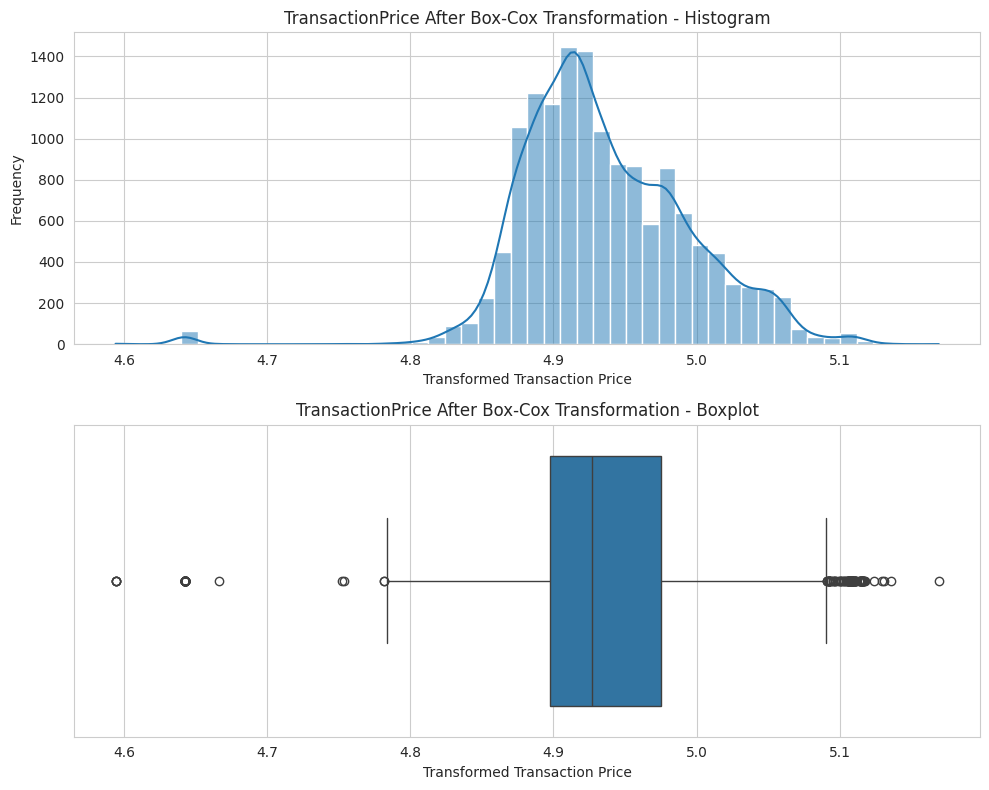

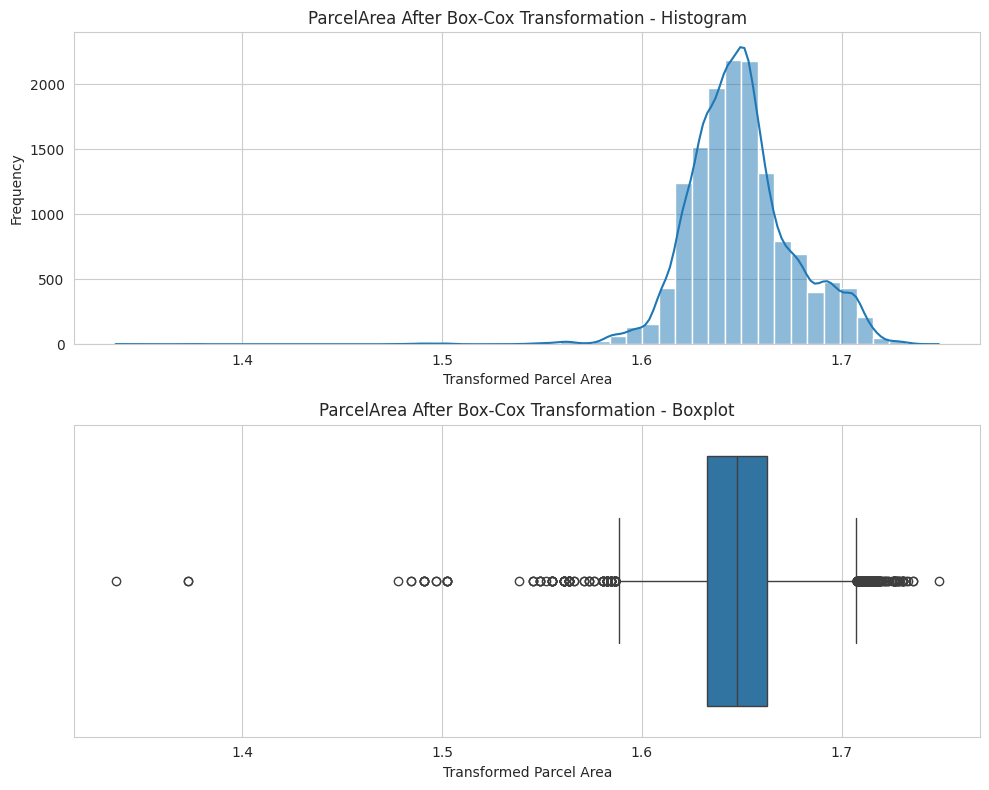

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox

sns.set_style("whitegrid")

# Create a copy to store transformed data
df_transformed = df_before_capping.copy()

# --- 1. Apply Box-Cox Transformation to 'TransactionPrice' ---
# Box-Cox requires positive data. Ensure all values are strictly positive.
# TransactionPrice usually starts from 0 or positive, but we can add a small constant if any zeros exist.
# For demonstration, we'll assume current data is non-negative and handle if 0s exist by adding a tiny epsilon.
min_price = df_transformed['TransactionPrice'].min()
if min_price <= 0:
    print(f"Warning: TransactionPrice contains non-positive values (min={min_price}). Adding a small constant before Box-Cox.")
    df_transformed['TransactionPrice_bc'], lambda_price = boxcox(df_transformed['TransactionPrice'] + 1e-6)
else:
    df_transformed['TransactionPrice_bc'], lambda_price = boxcox(df_transformed['TransactionPrice'])

print(f"Optimal lambda for TransactionPrice: {lambda_price:.4f}")

# --- 2. Apply Box-Cox Transformation to 'ParcelArea' ---
# ParcelArea also needs to be positive.
min_area = df_transformed['ParcelArea'].min()
if min_area <= 0:
    print(f"Warning: ParcelArea contains non-positive values (min={min_area}). Adding a small constant before Box-Cox.")
    df_transformed['ParcelArea_bc'], lambda_area = boxcox(df_transformed['ParcelArea'] + 1e-6)
else:
    df_transformed['ParcelArea_bc'], lambda_area = boxcox(df_transformed['ParcelArea'])

print(f"Optimal lambda for ParcelArea: {lambda_area:.4f}")

# --- 3. Plot Transformed 'TransactionPrice' distributions ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_transformed['TransactionPrice_bc'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('TransactionPrice After Box-Cox Transformation - Histogram')
axes[0].set_xlabel('Transformed Transaction Price')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_transformed['TransactionPrice_bc'], ax=axes[1])
axes[1].set_title('TransactionPrice After Box-Cox Transformation - Boxplot')
axes[1].set_xlabel('Transformed Transaction Price')

plt.tight_layout()
plt.show()

# --- 4. Plot Transformed 'ParcelArea' distributions ---
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

sns.histplot(df_transformed['ParcelArea_bc'], kde=True, ax=axes[0], bins=50)
axes[0].set_title('ParcelArea After Box-Cox Transformation - Histogram')
axes[0].set_xlabel('Transformed Parcel Area')
axes[0].set_ylabel('Frequency')

sns.boxplot(x=df_transformed['ParcelArea_bc'], ax=axes[1])
axes[1].set_title('ParcelArea After Box-Cox Transformation - Boxplot')
axes[1].set_xlabel('Transformed Parcel Area')

plt.tight_layout()
plt.show()

## Comparative Summary of Outlier Handling Methods

This section compares the impact, pros, and cons of the outlier handling methods demonstrated:

### 1. Outlier Capping (90th percentile, as done initially)
*   **Impact**: Caps extreme values at a specified percentile, keeping all data points but reducing the influence of extreme high (or low) values. It makes the distribution less skewed and pulls in the tails without removing any data.
*   **Pros**: Retains all observations, useful when outliers might contain valuable information but their magnitude is problematic. It's robust to extreme values.
*   **Cons**: Can distort the original distribution by creating a peak at the capping point, potentially reducing variance and making it harder to distinguish between genuine extreme values and less extreme ones near the cap.

### 2. IQR-based Outlier Removal
*   **Impact**: Removes data points outside the fences (Q1 - 1.5*IQR, Q3 + 1.5*IQR). This method is effective in cleaning data by focusing on the central tendency and spread of the majority of data.
*   **Pros**: Non-parametric, meaning it doesn't assume a specific data distribution (like normality). Robust to extreme values and skewness, as it's based on quartiles. Clearly defines 'typical' data range.
*   **Cons**: Can remove a significant number of data points, potentially leading to loss of information if the outliers are valid data. The definition of an outlier (1.5*IQR) is somewhat arbitrary and might not be suitable for all datasets.

### 3. Z-score-based Outlier Removal
*   **Impact**: Removes data points whose standardized score (Z-score) exceeds a certain threshold (e.g., |Z| > 3). This method is effective for identifying outliers in normally distributed data.
*   **Pros**: Statistically intuitive and easy to implement. Effective when data is truly normally distributed, as it directly measures distance from the mean in terms of standard deviations.
*   **Cons**: Highly sensitive to the mean and standard deviation, which are themselves influenced by outliers. If the data is not normally distributed (e.g., highly skewed), Z-scores can incorrectly identify normal data points as outliers or miss true outliers. Tends to be less aggressive in removing outliers compared to IQR for skewed distributions.

### 4. Box-Cox Transformation
*   **Impact**: Transforms non-normally distributed data into a more normal-like distribution, compressing extreme values and making the variance more stable. This implicitly handles outliers by reducing their relative extremity.
*   **Pros**: Can stabilize variance, improve linearity, and make data more Gaussian, which benefits many statistical models that assume normality. It's a data transformation rather than removal, so no data points are discarded.
*   **Cons**: Only applicable to positive data. The interpretability of transformed values can be challenging. While it makes distributions more symmetric, it doesn't explicitly 'remove' outliers but rather reduces their impact by changing the scale.

### Conclusion
Each method serves different purposes and has different assumptions. Outlier capping is good for retaining data while limiting extremes. IQR removal is robust to non-normal data but can discard valid information. Z-score removal is suitable for near-normal distributions but sensitive to skew. Box-Cox transformation is excellent for normalizing distributions and stabilizing variance, implicitly managing outliers without removal, but it requires positive data and alters interpretability. The choice of method depends on the data's characteristics, the goal of the analysis, and the acceptable trade-offs between data retention and statistical robustness.

## Compare the Outlier Handling Methods

### Subtask:
Summarize and compare the impact of capping, IQR-based removal, Z-score-based removal, and Box-Cox transformation on the distributions of 'TransactionPrice' and 'ParcelArea', discussing their respective pros and cons.


## Summary:

### Q&A
1.  **What is the Interquartile Range (IQR) method for outlier handling?**
    The IQR method is a non-parametric approach that defines outliers as data points falling below Q1 - 1.5 \* IQR or above Q3 + 1.5 \* IQR. It's robust to skewness.

2.  **What is the Z-score method for outlier handling?**
    The Z-score method identifies outliers as data points whose Z-score (number of standard deviations from the mean) exceeds a certain threshold (e.g., 3). It assumes the data is normally distributed.

3.  **What is the Box-Cox Transformation method for outlier handling?**
    Box-Cox transformation is a power transformation that converts non-normally distributed data into a more normal distribution. It implicitly handles outliers by compressing extreme values without removing data points. It is only applicable to positive data.

4.  **How many outliers were conceptually removed from 'TransactionPrice' and 'ParcelArea' using the IQR method?**
    Using the IQR method, 1232 outliers were conceptually removed from 'TransactionPrice', and 1486 outliers were conceptually removed from 'ParcelArea'.

5.  **How many outliers were conceptually removed from 'TransactionPrice' and 'ParcelArea' using the Z-score method (threshold=3)?**
    Using the Z-score method with a threshold of 3, 216 outliers were conceptually removed from 'TransactionPrice', and 295 outliers were conceptually removed from 'ParcelArea'.

### Data Analysis Key Findings
*   **IQR Outlier Removal:**
    *   For 'TransactionPrice', 1232 outliers were identified and conceptually removed.
    *   For 'ParcelArea', 1486 outliers were identified and conceptually removed.
    *   This method significantly reduced the range and spread of both variables, creating more concentrated distributions around the central values.
*   **Z-score Outlier Removal:**
    *   Using a Z-score threshold of 3, 216 outliers were identified and conceptually removed from 'TransactionPrice'.
    *   For 'ParcelArea', 295 outliers were identified and conceptually removed.
    *   Compared to IQR, the Z-score method removed fewer outliers for both variables, suggesting less aggressive outlier treatment or a closer-to-normal distribution within the remaining data points.
*   **Box-Cox Transformation:**
    *   The optimal lambda for 'TransactionPrice' was -0.1855, and for 'ParcelArea' it was -0.5639.
    *   The transformation successfully made the distributions of both 'TransactionPrice' and 'ParcelArea' appear more symmetrical and closer to a normal distribution, with extreme values being compressed rather than removed.
*   **Method Comparison:**
    *   **Outlier Capping** retains all observations but can distort the original distribution by creating peaks at the capping points.
    *   **IQR-based Removal** is robust to non-normal data but can lead to significant data loss (e.g., 1232 `TransactionPrice` and 1486 `ParcelArea` outliers removed).
    *   **Z-score-based Removal** is suitable for normally distributed data but sensitive to existing outliers and less aggressive for skewed data (e.g., 216 `TransactionPrice` and 295 `ParcelArea` outliers removed).
    *   **Box-Cox Transformation** normalizes data without removing points, but it alters interpretability and requires positive data.

### Insights or Next Steps
*   The choice of outlier handling method significantly impacts the number of data points retained and the shape of the distribution. For 'TransactionPrice' and 'ParcelArea', the IQR method removed substantially more outliers than the Z-score method, indicating strong skewness in the original data where the IQR's non-parametric nature is more effective.
*   Given the high number of outliers removed by IQR and the significant transformation required by Box-Cox (lambdas of -0.1855 and -0.5639, respectively), these variables ('TransactionPrice' and 'ParcelArea') likely have highly skewed distributions. Future modeling efforts should consider which method best aligns with the assumptions of the chosen model and the desired trade-off between outlier removal and data retention.
